# Libraries used in the work

In [54]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.decomposition import PCA
from sklearn import preprocessing
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as knn

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Importing of the dataset

In [3]:
fname = join(os.getcwd(),'data','data3SS2009.mat')

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = np.int32(mat_contents['labels'].reshape(Nc))

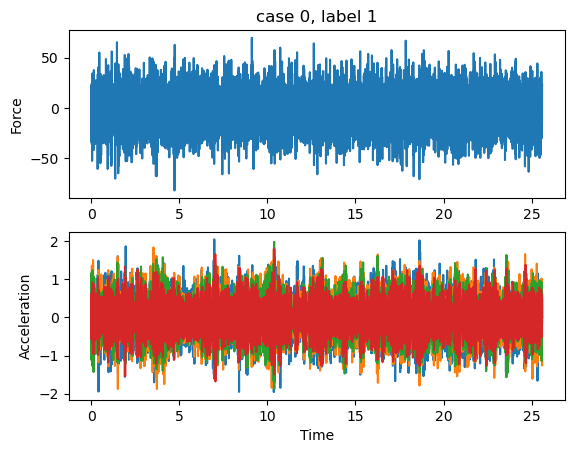

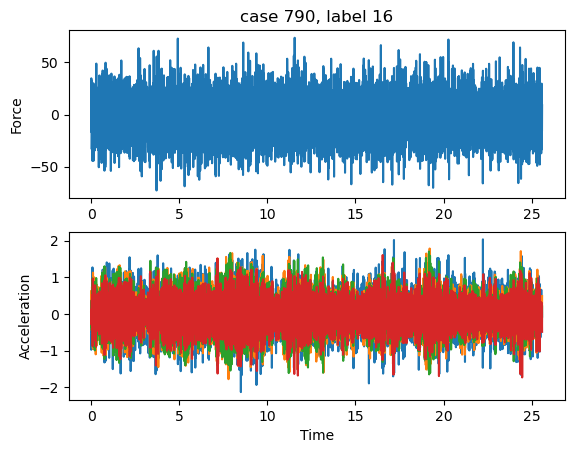

In [4]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

# Week 2

### Autoregression of each channel (CHn) and each row (850)

In [5]:
Ch2_ar = []
for i in range(850):
    res = AutoReg(Ch2.T[i], lags = 30).fit()
    Ch2_ar.append(res.params)

In [6]:
Ch3_ar = []
for i in range(850):
    res = AutoReg(Ch3.T[i], lags = 30).fit()
    Ch3_ar.append(res.params)

In [7]:
Ch4_ar = []
for i in range(850):
    res = AutoReg(Ch4.T[i], lags = 30).fit()
    Ch4_ar.append(res.params)

In [8]:
Ch5_ar = []
for i in range(850):
    res = AutoReg(Ch5.T[i], lags = 30).fit()
    Ch5_ar.append(res.params)

### X1 definition

In [9]:
X1 = np.concatenate((Ch2_ar, Ch3_ar, Ch4_ar, Ch5_ar), axis = 1)
X1.shape

(850, 124)

### PCA of X1

In [10]:
pca = PCA()
principalComponents = pca.fit_transform(X1)

<function matplotlib.pyplot.show(close=None, block=None)>

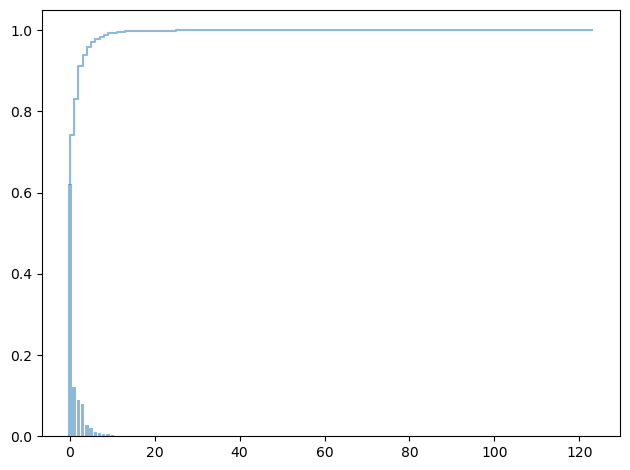

In [11]:
exp_var_ratio = pca.explained_variance_ratio_
cum_sum_principalvalues = np.cumsum(exp_var_ratio)

plt.bar(range(0, len(exp_var_ratio)), exp_var_ratio, alpha = .5)
plt.step(range(0, len(cum_sum_principalvalues)), cum_sum_principalvalues, alpha = .5)
plt.tight_layout()
plt.show

### Testing how many components are needed to get 99% of cum_sum_principalvalues

In [12]:
for i in range(len(cum_sum_principalvalues)):
    if cum_sum_principalvalues[i] > .99:
        print(i)
        n_c = i
        break

10


### Generating X2 

In [13]:
pca = PCA(n_components = n_c)
X2 = pca.fit_transform(X1)
X2.shape

(850, 10)

In [14]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

indDam = y > 9
X2red = pd.concat([pd.DataFrame(scaler.fit_transform(X2)), pd.DataFrame({'target': indDam})], axis =1)

X2red.describe()

,0,1,2,3,4,5,6,7,8,9
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,-0.252236,-0.312300,-0.234238,-0.012273,-0.129277,-0.010447,-0.085838,-0.070841,-0.195128,-0.051741
std,0.582294,0.450444,0.235347,0.427869,0.369069,0.354312,0.367903,0.350867,0.289218,0.342014
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.820990,-0.605487,-0.402430,-0.285883,-0.381873,-0.189913,-0.359643,-0.277146,-0.345575,-0.254795
50%,-0.425344,-0.470663,-0.246178,0.038969,-0.206845,-0.028918,-0.119966,-0.071913,-0.167205,-0.007364
75%,0.352590,-0.222251,-0.077246,0.292005,0.141888,0.149019,0.141957,0.119499,-0.040920,0.172722
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### X2 Visualizing  

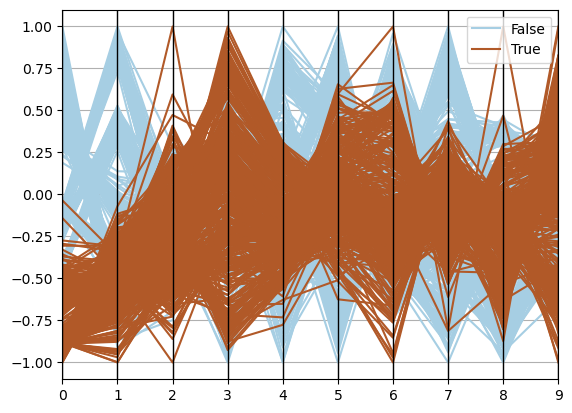

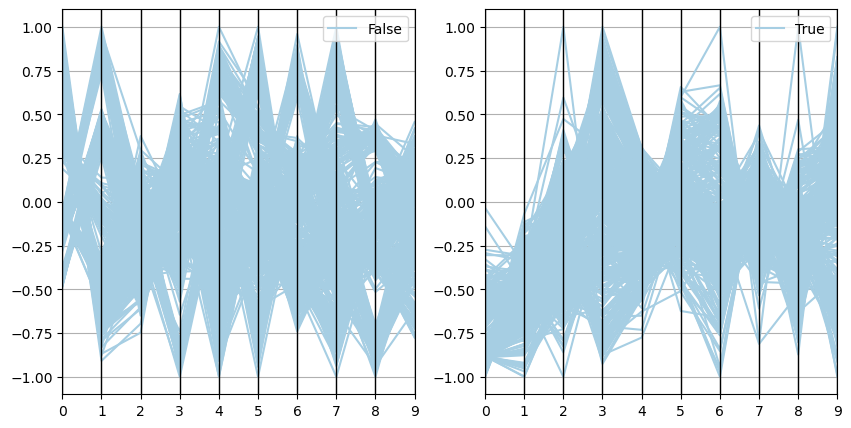

In [16]:
plt.figure()
pd.plotting.parallel_coordinates(X2red, 'target', colormap = plt.get_cmap('Paired'))
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
pd.plotting.parallel_coordinates(X2red[X2red['target'] == 0], 'target', colormap = plt.get_cmap('Paired'))
plt.subplot(122)
pd.plotting.parallel_coordinates(X2red[X2red['target'] == 1], 'target', colormap = plt.get_cmap('Paired'))
plt.show()

### X1 Visualizing

In [17]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

indDam = y > 9
X1red = pd.concat([pd.DataFrame(scaler.fit_transform(X1)), pd.DataFrame({'target': indDam})], axis =1)

X1red.describe()

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,...,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,0.105433,-0.466393,-0.368279,-0.319432,-0.309426,-0.340147,-0.321540,-0.352759,-0.348480,-0.378835,...,-0.170588,-0.432553,-0.162422,-0.396875,0.010858,-0.325698,-0.014087,-0.158016,0.101410,-0.103422
std,0.307770,0.310621,0.321682,0.316071,0.293349,0.283801,0.279673,0.265238,0.255785,0.244776,...,0.332810,0.339614,0.337334,0.385342,0.302184,0.414374,0.327901,0.411179,0.322526,0.382466
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.030912,-0.662084,-0.585507,-0.541926,-0.510796,-0.526659,-0.503952,-0.534202,-0.520459,-0.544958,...,-0.401479,-0.659222,-0.393076,-0.664043,-0.191710,-0.625665,-0.230897,-0.486157,-0.110505,-0.426397
50%,0.159086,-0.541107,-0.437366,-0.364918,-0.346037,-0.377958,-0.357425,-0.383766,-0.375702,-0.402568,...,-0.159952,-0.533084,-0.150206,-0.515988,0.037858,-0.447081,-0.025697,-0.214718,0.128824,-0.165110
75%,0.288540,-0.347539,-0.207242,-0.137295,-0.161409,-0.213181,-0.190548,-0.214557,-0.197405,-0.242709,...,0.029129,-0.327614,0.043244,-0.239233,0.189648,-0.092190,0.199566,0.137095,0.337049,0.206444
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


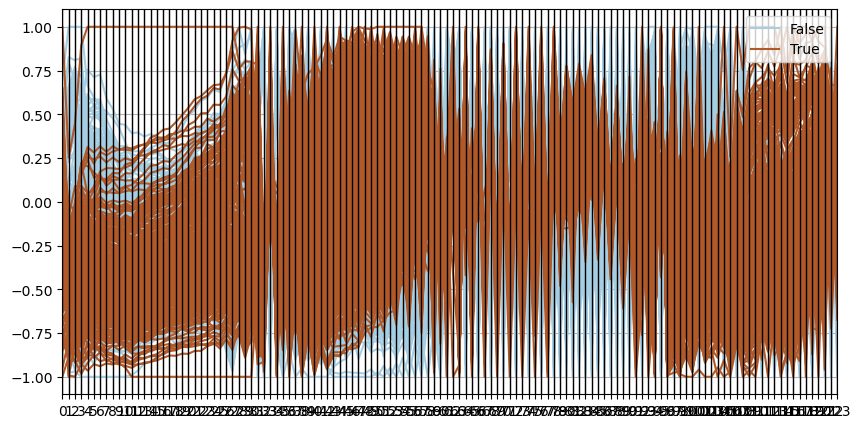

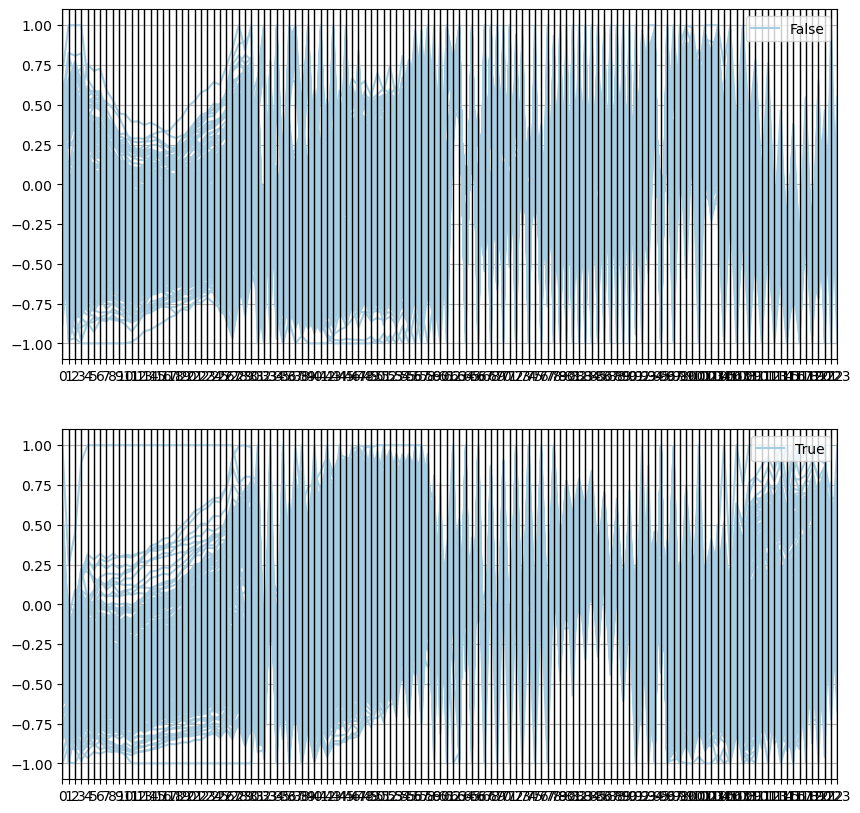

In [19]:
plt.figure(figsize=(10,5))
pd.plotting.parallel_coordinates(X1red, 'target', colormap = plt.get_cmap('Paired'))
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(211)
pd.plotting.parallel_coordinates(X1red[X1red['target'] == 0], 'target', colormap = plt.get_cmap('Paired'))
plt.subplot(212)
pd.plotting.parallel_coordinates(X1red[X1red['target'] == 1], 'target', colormap = plt.get_cmap('Paired'))
plt.show()

### Rescaling of X1 and X2

In [20]:
X1scaled = scaler.fit_transform(X1)
X2scaled = scaler.fit_transform(X2)

### Softmax linear model to test X1

In [21]:
softmax_reg1 = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C=.09)
y1 = softmax_reg1.fit(X1scaled, y)
y1_pred = np.int32(y1.predict(X1scaled))

### Softmax linear model to test X2

In [22]:
softmax_reg2 = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C=8)
y2 = softmax_reg2.fit(X2scaled, y)
y2_pred = np.int32(y2.predict(X2scaled))

### Accuracy of softmax linear model to X1 and X2

In [23]:
def accuracy(model, y_pred):
    error_count = 0
    for i in range(len(y)):
        if (y_pred[i]-y[i]) > 0:
            error_count += 1

    print(model, 'accuracy:', str(100*(1 - error_count/len(y))), '%')

In [24]:
accuracy('Softmax linear model in X1', y1_pred)
accuracy('Softmax linear model in X2', y2_pred)

Softmax linear model in X1 accuracy: 99.29411764705883 %
Softmax linear model in X2 accuracy: 98.94117647058823 %


# Week 3

### Support vector machine models

In [25]:
linear_svc_1 = svm.SVC(C=.1, kernel='linear', random_state=0)
linear_svc_2 = svm.SVC(C=1, kernel='linear', random_state=0)
linear_svc_3 = svm.SVC(C=10, kernel='linear', random_state=0)

poly2_svc_1 = svm.SVC(C=.1, kernel='poly', degree = 2, random_state=0)
poly2_svc_2 = svm.SVC(C=1, kernel='poly', degree = 2, random_state=0)
poly2_svc_3 = svm.SVC(C=10, kernel='poly', degree = 2, random_state=0)

poly3_svc_1 = svm.SVC(C=.1, kernel='poly', degree = 3, random_state=0)
poly3_svc_2 = svm.SVC(C=1, kernel='poly', degree = 3, random_state=0)
poly3_svc_3 = svm.SVC(C=10, kernel='poly', degree = 3, random_state=0)

sigmoid_svc_1 = svm.SVC(C=.1, kernel='sigmoid', random_state=0)
sigmoid_svc_2 = svm.SVC(C=1, kernel='sigmoid', random_state=0)
sigmoid_svc_3 = svm.SVC(C=10, kernel='sigmoid', random_state=0)

In [26]:
clf = linear_svc_1.fit(X1, y)
yh_lsvc1x1 = clf.predict(X1)
clf = linear_svc_1.fit(X2, y)
yh_lsvc1x2 = clf.predict(X2)
accuracy('Linear svc with C=.1 to X1', yh_lsvc1x1)
accuracy('Linear svc with C=.1 to X2', yh_lsvc1x2)

Linear svc with C=.1 to X1 accuracy: 99.29411764705883 %
Linear svc with C=.1 to X2 accuracy: 98.11764705882354 %


In [27]:
clf = linear_svc_2.fit(X1, y)
yh_lsvc2x1 = clf.predict(X1)
clf = linear_svc_2.fit(X2, y)
yh_lsvc2x2 = clf.predict(X2)
accuracy('Linear svc with C=1 to X1', yh_lsvc2x1)
accuracy('Linear svc with C=1 to X2', yh_lsvc2x2)

Linear svc with C=1 to X1 accuracy: 100.0 %
Linear svc with C=1 to X2 accuracy: 99.41176470588235 %


In [28]:
clf = linear_svc_3.fit(X1, y)
yh_lsvc3x1 = clf.predict(X1)
clf = linear_svc_3.fit(X2, y)
yh_lsvc3x2 = clf.predict(X2)
accuracy('Linear svc with C=10 to X1', yh_lsvc3x1)
accuracy('Linear svc with C=10 to X2', yh_lsvc3x2)

Linear svc with C=10 to X1 accuracy: 100.0 %
Linear svc with C=10 to X2 accuracy: 99.1764705882353 %


In [29]:
clf = poly2_svc_1.fit(X1, y)
yh_p2svc1x1 = clf.predict(X1)
clf = poly2_svc_1.fit(X2, y)
yh_p2svc1x2 = clf.predict(X2)
accuracy('Degree 2 polynomial svc with C=.1 to X1', yh_p2svc1x1)
accuracy('Degree 2 polynomial svc with C=.1 to X2', yh_p2svc1x2)

Degree 2 polynomial svc with C=.1 to X1 accuracy: 89.05882352941177 %
Degree 2 polynomial svc with C=.1 to X2 accuracy: 96.82352941176471 %


In [30]:
clf = poly2_svc_2.fit(X1, y)
yh_p2svc2x1 = clf.predict(X1)
clf = poly2_svc_2.fit(X2, y)
yh_p2svc2x2 = clf.predict(X2)
accuracy('Degree 2 polynomial svc with C=1 to X1', yh_p2svc2x1)
accuracy('Degree 2 polynomial svc with C=1 to X2', yh_p2svc2x2)

Degree 2 polynomial svc with C=1 to X1 accuracy: 95.17647058823529 %
Degree 2 polynomial svc with C=1 to X2 accuracy: 97.41176470588235 %


In [31]:
clf = poly2_svc_3.fit(X1, y)
yh_p2svc3x1 = clf.predict(X1)
clf = poly2_svc_3.fit(X2, y)
yh_p2svc3x2 = clf.predict(X2)
accuracy('Degree 2 polynomial svc with C=10 to X1', yh_p2svc3x1)
accuracy('Degree 2 polynomial svc with C=10 to X2', yh_p2svc3x2)

Degree 2 polynomial svc with C=10 to X1 accuracy: 98.94117647058823 %
Degree 2 polynomial svc with C=10 to X2 accuracy: 99.29411764705883 %


In [32]:
clf = poly3_svc_1.fit(X1, y)
yh_p3svc1x1 = clf.predict(X1)
clf = poly3_svc_1.fit(X2, y)
yh_p3svc1x2 = clf.predict(X2)
accuracy('Degree 3 polynomial svc with C=.1 to X1', yh_p3svc1x1)
accuracy('Degree 3 polynomial svc with C=.1 to X2', yh_p3svc1x2)

Degree 3 polynomial svc with C=.1 to X1 accuracy: 86.23529411764706 %
Degree 3 polynomial svc with C=.1 to X2 accuracy: 98.11764705882354 %


In [33]:
clf = poly3_svc_2.fit(X1, y)
yh_p3svc2x1 = clf.predict(X1)
clf = poly3_svc_2.fit(X2, y)
yh_p3svc2x2 = clf.predict(X2)
accuracy('Degree 3 polynomial svc with C=1 to X1', yh_p3svc2x1)
accuracy('Degree 3 polynomial svc with C=1 to X2', yh_p3svc2x2)

Degree 3 polynomial svc with C=1 to X1 accuracy: 96.23529411764706 %
Degree 3 polynomial svc with C=1 to X2 accuracy: 98.94117647058823 %


In [34]:
clf = poly3_svc_3.fit(X1, y)
yh_p3svc3x1 = clf.predict(X1)
clf = poly3_svc_3.fit(X2, y)
yh_p3svc3x2 = clf.predict(X2)
accuracy('Degree 3 polynomial svc with C=10 to X1', yh_p3svc3x1)
accuracy('Degree 3 polynomial svc with C=10 to X2', yh_p3svc3x2)

Degree 3 polynomial svc with C=10 to X1 accuracy: 99.76470588235294 %
Degree 3 polynomial svc with C=10 to X2 accuracy: 99.29411764705883 %


In [35]:
clf = sigmoid_svc_1.fit(X1, y)
yh_ssvc1x1 = clf.predict(X1)
clf = sigmoid_svc_1.fit(X2, y)
yh_ssvc1x2 = clf.predict(X2)
accuracy('Sigmoid svc with C=.1 to X1', yh_ssvc1x1)
accuracy('Sigmoid svc with C=.1 to X2', yh_ssvc1x2)

Sigmoid svc with C=.1 to X1 accuracy: 72.11764705882354 %
Sigmoid svc with C=.1 to X2 accuracy: 85.29411764705883 %


In [36]:
clf = sigmoid_svc_2.fit(X1, y)
yh_ssvc2x1 = clf.predict(X1)
clf = sigmoid_svc_2.fit(X2, y)
yh_ssvc2x2 = clf.predict(X2)
accuracy('Sigmoid svc with C=1 to X1', yh_ssvc2x1)
accuracy('Sigmoid svc with C=1 to X2', yh_ssvc2x2)

Sigmoid svc with C=1 to X1 accuracy: 72.11764705882354 %
Sigmoid svc with C=1 to X2 accuracy: 88.11764705882354 %


In [37]:
clf = sigmoid_svc_3.fit(X1, y)
yh_ssvc3x1 = clf.predict(X1)
clf = sigmoid_svc_3.fit(X2, y)
yh_ssvc3x2 = clf.predict(X2)
accuracy('Sigmoid svc with C=10 to X1', yh_ssvc3x1)
accuracy('Sigmoid svc with C=10 to X2', yh_ssvc3x2)

Sigmoid svc with C=10 to X1 accuracy: 72.0 %
Sigmoid svc with C=10 to X2 accuracy: 84.35294117647058 %


### k-NN models

In [39]:
knn_2 = knn(n_neighbors = 2, n_jobs = -1)
knn_3 = knn(n_neighbors = 3, n_jobs = -1)
knn_4 = knn(n_neighbors = 4, n_jobs = -1)
knn_5 = knn(n_neighbors = 5, n_jobs = -1)
knn_6 = knn(n_neighbors = 6, n_jobs = -1)
knn_7 = knn(n_neighbors = 7, n_jobs = -1)
knn_8 = knn(n_neighbors = 8, n_jobs = -1)
knn_9 = knn(n_neighbors = 9, n_jobs = -1)
knn_10 = knn(n_neighbors = 10, n_jobs = -1)

In [55]:
clf = knn_2.fit(X1, y)
yh_knn2x1 = clf.predict(X1)
clf = knn_2.fit(X2, y)
yh_knn2x2 = clf.predict(X2)
accuracy('kNN with 2 neighbors in X1', yh_knn2x1)
accuracy('kNN with 2 neighbors in X2', yh_knn2x2)

kNN with 2 neighbors in X1 accuracy: 100.0 %
kNN with 2 neighbors in X2 accuracy: 100.0 %


In [56]:
clf = knn_3.fit(X1, y)
yh_knn3x1 = clf.predict(X1)
clf = knn_3.fit(X2, y)
yh_knn3x2 = clf.predict(X2)
accuracy('kNN with 3 neighbors in X1', yh_knn3x1)
accuracy('kNN with 3 neighbors in X2', yh_knn3x2)

kNN with 3 neighbors in X1 accuracy: 99.1764705882353 %
kNN with 3 neighbors in X2 accuracy: 98.82352941176471 %


In [57]:
clf = knn_4.fit(X1, y)
yh_knn4x1 = clf.predict(X1)
clf = knn_4.fit(X2, y)
yh_knn4x2 = clf.predict(X2)
accuracy('kNN with 4 neighbors in X1', yh_knn4x1)
accuracy('kNN with 4 neighbors in X2', yh_knn4x2)

kNN with 4 neighbors in X1 accuracy: 99.6470588235294 %
kNN with 4 neighbors in X2 accuracy: 99.29411764705883 %


In [58]:
clf = knn_5.fit(X1, y)
yh_knn5x1 = clf.predict(X1)
clf = knn_5.fit(X2, y)
yh_knn5x2 = clf.predict(X2)
accuracy('kNN with 5 neighbors in X1', yh_knn5x1)
accuracy('kNN with 5 neighbors in X2', yh_knn5x2)

kNN with 5 neighbors in X1 accuracy: 98.82352941176471 %
kNN with 5 neighbors in X2 accuracy: 98.82352941176471 %


In [59]:
clf = knn_6.fit(X1, y)
yh_knn6x1 = clf.predict(X1)
clf = knn_6.fit(X2, y)
yh_knn6x2 = clf.predict(X2)
accuracy('kNN with 6 neighbors in X1', yh_knn6x1)
accuracy('kNN with 6 neighbors in X2', yh_knn6x2)

kNN with 6 neighbors in X1 accuracy: 99.05882352941177 %
kNN with 6 neighbors in X2 accuracy: 99.05882352941177 %


In [60]:
clf = knn_7.fit(X1, y)
yh_knn7x1 = clf.predict(X1)
clf = knn_7.fit(X2, y)
yh_knn7x2 = clf.predict(X2)
accuracy('kNN with 7 neighbors in X1', yh_knn7x1)
accuracy('kNN with 7 neighbors in X2', yh_knn7x2)

kNN with 7 neighbors in X1 accuracy: 98.70588235294117 %
kNN with 7 neighbors in X2 accuracy: 98.23529411764706 %


In [61]:
clf = knn_8.fit(X1, y)
yh_knn8x1 = clf.predict(X1)
clf = knn_8.fit(X2, y)
yh_knn8x2 = clf.predict(X2)
accuracy('kNN with 8 neighbors in X1', yh_knn8x1)
accuracy('kNN with 8 neighbors in X2', yh_knn8x2)

kNN with 8 neighbors in X1 accuracy: 98.94117647058823 %
kNN with 8 neighbors in X2 accuracy: 98.70588235294117 %


In [62]:
clf = knn_9.fit(X1, y)
yh_knn9x1 = clf.predict(X1)
clf = knn_9.fit(X2, y)
yh_knn9x2 = clf.predict(X2)
accuracy('kNN with 9 neighbors in X1', yh_knn9x1)
accuracy('kNN with 9 neighbors in X2', yh_knn9x2)

kNN with 9 neighbors in X1 accuracy: 98.47058823529412 %
kNN with 9 neighbors in X2 accuracy: 98.3529411764706 %


In [63]:
clf = knn_10.fit(X1, y)
yh_knn10x1 = clf.predict(X1)
clf = knn_10.fit(X2, y)
yh_knn10x2 = clf.predict(X2)
accuracy('kNN with 10 neighbors in X1', yh_knn10x1)
accuracy('kNN with 10 neighbors in X2', yh_knn10x2)

kNN with 10 neighbors in X1 accuracy: 98.47058823529412 %
kNN with 10 neighbors in X2 accuracy: 98.11764705882354 %
